### Data Processing

If you are not using Google Colab, you need not run this. The purpose of this element is to navigate to the files on Google Drive.

In [0]:
from google.colab import drive
import os

# Mount my Google Drrive
drive.mount('/content/drive')

# Go to the directory with the 583 data
os.chdir('/content/drive/My Drive/data_583')
!pwd
!ls data

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/data_583
breed_labels.csv     test_images		train_metadata
color_labels.csv     test_metadata		train_sentiment
picked_pictures.npy  test_sentiment		train_sentiment_parsed.csv
state_labels.csv     test_sentiment_parsed.csv
test		     train


In [0]:
import os
from PIL import Image
import numpy as np
import pandas as pd

from keras.utils import to_categorical

import numpy as np

from tqdm import tqdm

numeric_cols = [
    'Age',
    'Quantity', 'Fee', 'State',
    'VideoAmt', 'PhotoAmt', 'Type'
]

one_hot_cols = {
    #'Type': 2, 
    'Breed1': 307, 'Breed2': 307,
    'Gender': 3, 'Color1': 7, 'Color2': 7,
    'Color3': 7,
    'MaturitySize': 5,
    'FurLength': 4, 'Vaccinated': 3,
    'Dewormed': 3, 'Sterilized': 3,
    'Health': 4, 'State': 15
}

def one_hot_encode(df, col, num_class=None, labels=None, inplace=False):
    ''' Takes in dataframe df and replaces col with num_class columns
        For example, use as follows
        for col, num_class in data.one_hot_cols.items():
            one_hot_encode(train_df, col, num_class)
    '''
    # get the true values from data
    column_values = np.sort(df[col].dropna().unique())
    if num_class == None:
        num_class = len(column_values)
    if num_class == 2:
        # These can just be boolean
        if inplace:
            df[col] = (df[col] == column_values[0]).astype(int)
        else:
            return (df[col] == column_values[0]).astype(int)
    else:        
        if labels is not None:
            res = np.zeros((len(df), num_class))
            for i, label in enumerate(labels):
                if inplace:
                    df[col+'_'+str(label)] = (df[col] == label).astype(int)
                else:
                    one_hot = np.zeros(num_class)
                    one_hot[i] = 1
                    res[df[col] == label] = one_hot
        else:
            res = np.zeros((len(df), num_class))
            for i in range(num_class):
                if (i >= len(column_values)):
                    break # Index out of bounds
                cur_value = column_values[i]

                if inplace:
                    df[col+'_'+str(cur_value)] = (df[col] == cur_value).astype(int)
                else:
                    one_hot = np.zeros(num_class)
                    one_hot[i] = 1
                    res[df[col] == cur_value] = one_hot
    
        if inplace:
            # delete original column
            df.drop(col, axis=1, inplace=True)
        else:
            return res

def load_data(fname):
    return pd.read_csv(fname)


Using TensorFlow backend.


In [0]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

def load_train_ohe(lbl):
    dta = load_data('data/train/train.csv')
    
    X = []
    Y = []
    
    for i, row in dta.iterrows():
        x = row[lbl]
        y = row['AdoptionSpeed']
        
        X.append(x)
        Y.append(y)
    
    return np.array(X), np.array(Y)

def train_embedding(name, dim=8):
    print('Training embedding for', name)
    
    # Extract data
    W, Z = load_train_ohe(name)
    Ws = sorted(list(set(W)))
    mapping = {c: i for i, c in enumerate(Ws)}
    W = [mapping[w] for w in W]
    Z = to_categorical(Z)

    from keras.models import Sequential
    from keras.layers import Embedding, Dense, Flatten
    
    # The embedding layer
    emb = Embedding(len(W), dim, input_length=1)

    # Make a training model for the embedding
    model = Sequential()
    model.add(emb)
    model.add(Flatten())
    model.add(Dense(5, activation='softmax'))

    # Train the embedding to best predict the label (pretrain the labels)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    #model.summary()
    model.fit(np.array(W), Z, epochs=8, validation_split=0.2)
    
    # Reduce the model
    model = Sequential()
    model.add(emb)
    model.add(Flatten())
    
    X = model.predict(np.array([[i] for i in range(len(mapping))]))
    mapping = {
        c: list(X[mapping[c]])
        for c in mapping
    }
    
    return mapping

# Generate an embedder for each of the one hot encodable models
"""
ohe = {
    k: train_embedding(k, dim=4)
    for k in one_hot_cols
}
"""


'\nohe = {\n    k: train_embedding(k, dim=4)\n    for k in one_hot_cols\n}\n'

In [0]:

def load_pet_files(regdir):
    """ Extracts all of the files associated with each pet listed
    by the 'PetID' tag.

    regdir - The directory containing the files

    returns a dictionary containing keypairs (k, v) such that v
    matches the regex (k\-.*) where k is the key (a valid PetID).
    """
    fname = os.path.join(regdir, 'picked_pictures.npy')
    
    print(f"Images will be loaded from {fname}")
    return np.load(fname, allow_pickle=True).item()

def load_pet_pics(regdir):
    """ Extracts all of the files associated with each pet listed
    by the 'PetID' tag.

    regdir - The directory containing the files

    returns a dictionary containing keypairs (k, v) such that v
    matches the regex (k\-.*) where k is the key (a valid PetID).
    """
    if os.path.isfile(os.path.join(regdir + 'picked_pictures.npy')):
        print("Images loaded from existing file")
        return np.load(os.path.join(regdir + 'picked_pictures.npy'), allow_pickle=True).item()
    pfiles = {}

    # Extract the pet names
    for f in tqdm(os.listdir(regdir), desc='Loading Pet Files'):
        # Extract the name
        n = f[:f.index('-')]
        url = os.path.join(regdir, f)
        
        if n in pfiles:
            # Add to the entry
            pfiles[n].append(img)

        else:
            # Add a new entry
            pfiles[n] = [img]

    np.save(os.path.join(regdir + 'picked_pictures.npy'), pfiles)
    return pfiles

def load_train_data(is_train = True):
    # Get the annotations for each pet
    dta = load_data('data/train/train.csv' if is_train else 'data/test/test.csv')
     
    # Get the pet pictures
    try:
        petpics = load_pet_files('data/') if is_train else load_pet_pics('data/test_images')
    except:
        print('Could not load pet pictures')
        petpics = {}

    # Get the state ids
    states = load_data('data/state_labels.csv')
    states = states['StateID'].tolist()

    # Load parsed sentiment
    sentiment = load_data('data/{}_sentiment_parsed.csv'.format('train' if is_train else 'test'))

    X_num = []
    X_pic = []

    Y = []
    
    # Build a single object to store the X values
    X = [X_num, X_pic]
    
    """
    
    for k in one_hot_cols:
        one_hot_encode(dta, k, inplace=True)
        print('One hot encoded', k)
        """
    
    print('Constructing attribute data')
    for i, row in dta.iterrows():
        # Save the numeric values
        vals = list(row[numeric_cols])
        
        #state = [x == row['State'] for x in states] + [row['Gender'] == i for i in range(1,4)]
        #assert(sum(state) == 1)
        
        # Add all of the valid one-hot encodings
        #state = [row[k] for k in dta if any(q in k for q in one_hot_cols)]
            
        x = list(vals)# + state
        
            
        # Join sentiment on PetID
        s = sentiment[sentiment['PetID'] == row['PetID']]
        
        for col in s:
            if col not in row:
                row[col] = s.iloc[0][col]
                x.append(row[col])
        
        # Add the one-hot encodings
        x += list(row[one_hot_cols])
        
        """
        # Apply the one hot encodings
        for col in ohe:
            if row[col] in ohe[col]:
                x.extend(ohe[col][row[col]])
            else:
                x.extend(ohe[col][0])
        """
        
        # Save the pictures
        if row['PetID'] in petpics:
            X_pic.append(petpics[row['PetID']])
        else:
            X_pic.append([])
            
        # Save the data pair
        X_num.append(np.array(x))
        
        if is_train:
            Y.append(row['AdoptionSpeed'])
        else:
            Y.append(row['PetID'])

    # Laziness
    if len(X) == 1:
        X = np.array(X[0])
    else:
        X = list(map(np.array, X))

    Y = np.array(Y)

    return (X, Y)

def load_image(img_file, size=64):
    # print('img file:', img_file)
    img = Image.open(img_file)
    img = img.resize((size, size), Image.ANTIALIAS)
    return np.array(img)

In [0]:
# Get the data
X, Y = load_train_data()

Images will be loaded from data/picked_pictures.npy
Constructing attribute data


In [0]:
print([x.shape for x in X])
print(Y.shape)

[(14993, 23), (14993,)]
(14993,)


In [0]:
def shuffle(X, Y):
    idxs = list(range(len(Y)))
    
    if isinstance(X, list):
        for i in range(len(X)):
            X[i] = X[i][idxs]
    else:
        X = X[idxs]

    Y = Y[idxs]
    
    return X, Y

def split(X, Y, s=0.2):
    s = int(s * len(Y))
    
    if isinstance(X, list):
        X_train = [x[:-s] for x in X]
        X_test = [x[-s:] for x in X]
    else:
        X_train = X[:-s]
        X_test = X[-s:]

    Y_train = Y[:-s]
    Y_test = Y[-s:]

    return (X_train, Y_train), (X_test, Y_test)


def convert_for_all(X, Y):
    # For single image training, make a datapoint for each image or the default zero image
    Xs = [[], []]
    Ys = []
    for i in range(len(X[1])):
        if len(X[1][i]) == 0:
            Xs[0].append(X[0][i])
            Xs[1].append(np.zeros((64, 64, 3)))
            Ys.append(Y[i])
        else:
            # Make a datapoint for all images. We assume equal relevance of images
            for img in X[1][i]:
                if img.shape != (64, 64, 3):
                    # Convert to RGB (not a common occurence)
                    img = np.array([[[x, x, x] for x in row] for row in img])
                
                Xs[0].append(X[0][i])
                Xs[1].append(img)
                Ys.append(Y[i])
                
    print('Extracted', len(Y), 'datapoints')

    X = [
        np.array(Xs[0]),
        np.array(Xs[1])
    ]
    Y = np.array(Ys)

    return X, Y

def convert_for_poly(X, Y):
    # Find the max image count
    ct = max(len(x) for x in X[1])
    
    # Apply the base allocations
    Xs = [
        X[0],
        np.zeros((len(X[1]), ct, 64, 64, 3))
    ]
    
    # Insert the images
    for i, x in enumerate(X[1]):
        if len(x) > 0:
            Xs[i,:len(x)] = x
    
    return Xs, Y
    

def convert_for_single_axis(X, Y, ax=0):
    return X[ax], Y


In [0]:
X, Y = shuffle(X, Y)

### Architectures

In [0]:
def reg_loss(t, y):
    print('t:', t)
    print('y:', y)
    
    a = (35./6)*t**4 - (4./3)*t**3 + (29./12)*t**2 - (20./3)*t
    b = -.875*t**4 + (8 + 1./12)*t**3 + 9.125*t**2 + (95./12)*t + 1
    
    c = (a + b) / 2
    d = c - a
    return K.relu(K.abs(y - c) - d)

In [0]:
from keras.models import Sequential, Model
from keras.layers import *
from keras.callbacks import ModelCheckpoint

import tensorflow as tf

import math

class KaggleModel:
    def __init__(self, model, train, test):
        model.summary()
        self.model = model
        self.train_data = train
        self.test_data = test
        
        self.compiled = False

    def compile(self, optimizer='adam'):
        """ Compiles the model. Should be defined by the user.
        """
        if not self.compiled:
            print('Compiling', self.model.name)
            self.model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
            self.compiled = True

    def train(self, epochs=1):
        """ Default training behavior. Simply does a Model.fit(X, Y).
        """
        # Get the training data
        X_train, Y_train = self.train_data

        checkpoint = ModelCheckpoint('model.h5')
        
        # Fit to the data
        history = self.model.fit(X_train, Y_train, epochs=epochs, validation_data=self.test_data, callbacks=[checkpoint])
        if 'val_acc' in history.history:
            self.val_acc = history.history['val_acc'][-1]
        
        return history

    def predict(self, X):
        return self.model.predict(X)


def ResidualBlock(mdl):
    x = Input(shape=mdl.input_shape[1:])

    y = mdl(x)
    y = Add()([x, y])

    return Model(x, y)
        
class OheModel(KaggleModel):
    def __init__(self, train, test):
        kernel = Sequential(name='image_free_encoder')
        
        x = Input(shape=(len(numeric_cols) + len(one_hot_cols) + 3,))
        
        # Get the numerics
        z = Lambda(lambda z: z[:,:-len(one_hot_cols)])(x)
        
        """
        z = Dense(64)(z)
        z = BatchNormalization()(z)
        z = Activation('relu')(z)
        """
        
        ys = [z]
        
        # Split up the encodings
        i = len(numeric_cols) + 3 + len(one_hot_cols) - 1
        for k in one_hot_cols:
            y = Lambda(lambda z: z[:,i:i+1])(x)
            y = Embedding(one_hot_cols[k], math.ceil(math.sqrt(one_hot_cols[k])))(y)
            y = Flatten()(y)
            ys.append(y)
            i -= 1
        
        y = Concatenate()(ys)
        
        kernel.add(Model(x, y))
        kernel.add(BatchNormalization())
        
        kernel.add(Dropout(0.3))
        kernel.add(Dense(128))
        kernel.add(BatchNormalization())
        kernel.add(Activation('relu'))

        model = Sequential(name='image_free')
        model.add(kernel)
        
        model.add(Dropout(0.5))
        model.add(Dense(64))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        # Labels are one of [0, 1, 2, 3, 4]
        model.add(Dense(5, activation='softmax'))

        # Build using the built model
        super().__init__(model, train, test)
                
class RegModel(KaggleModel):
    def __init__(self, train, test):
        kernel = Sequential(name='image_free_encoder')
        
        x = Input(shape=(len(numeric_cols) + len(one_hot_cols) + 3,))
        
        # Get the numerics
        z = Lambda(lambda z: z[:,:-len(one_hot_cols)])(x)
        
        ys = [z]
        
        # Split up the encodings
        i = len(numeric_cols) + 3 + len(one_hot_cols) - 1
        for k in one_hot_cols:
            y = Lambda(lambda z: z[:,i:i+1])(x)
            y = Embedding(one_hot_cols[k], math.ceil(math.sqrt(one_hot_cols[k])))(y)
            y = Flatten()(y)
            ys.append(y)
            i -= 1
        
        y = Concatenate()(ys)
        
        kernel.add(Model(x, y))
        
        kernel.add(BatchNormalization())
        
        kernel.add(Dropout(0.3))
        kernel.add(Dense(128))
        kernel.add(BatchNormalization())
        kernel.add(Activation('relu'))

        model = Sequential(name='image_free')
        model.add(kernel)
        
        model.add(Dropout(0.5))
        model.add(Dense(64))
        model.add(BatchNormalization())
        model.add(Activation('sigmoid'))

        # Labels are one of [0, 1, 2, 3, 4]
        model.add(Dense(1, activation='relu'))

        # Build using the built model
        super().__init__(model, train, test)
        
    def compile(self, optimizer='adam'):
        """ Compiles the model. Should be defined by the user.
        """
        if not self.compiled:
            print('Compiling', self.model.name)
            self.model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['acc'])
            self.compiled = True

class SingleImageModel(KaggleModel):
    def __init__(self, train, test):
        # The model takes in attributes and an image.
        
        kernel = SingleImageModel.make_kernel()
        kernel.summary()

        model = Sequential(name='single_image')

        model.add(kernel)
        model.add(Dense(5, activation='softmax'))

        super().__init__(model, train, test)
    
    def make_kernel():
        kernel = Sequential(name='single_image_encoder')
        
        # Architecture for the images
        f = 64
        kernel.add(Conv2D(f, kernel_size=(7,7), strides=(1,1), padding='same', input_shape=(64, 64, 3)))
        kernel.add(BatchNormalization())

        while kernel.output_shape[1] > 4:
            for _ in range(2):
                # Old output is kept as residue
                x = z = Input(shape=(kernel.output_shape[1:]))

                for _ in range(2):
                    z = Activation('relu')(z)
                    z = Dropout(0.5)(z)
                    z = Conv2D(f, kernel_size=(5,5), strides=(1,1), padding='same')(z)
                    z = BatchNormalization()(z)
                
                # The sum of the residue and the new computation
                y = Add()([x, z])
                
                # Add the residual block
                blk = Model(x, y)
                kernel.add(blk)
            
            # Reduce dimension
            kernel.add(MaxPooling2D((2,2)))
            #f *= 2
            kernel.add(Conv2D(f, kernel_size=(1,1), strides=(1,1), padding='same', input_shape=(64, 64, 3)))
        
        
        kernel.add(Flatten())
        
        kernel.add(Dropout(0.5))
        kernel.add(Dense(128))
        kernel.add(BatchNormalization())
        kernel.add(Activation('relu'))
        
        return kernel

class UnionModel(KaggleModel):
    def __init__(self, models, train, test, freeze=True):
        
        xs = []
        ys = []
        for model in models:
            model = model.model
            x = Input(shape=model.input_shape[1:], name='{}_in'.format(model.name))
            # Get the first layer of the model. This is the encoder
            layer = model.get_layer(index=0)
            
            # It must not be trainable
            if freeze: layer.trainable = False
            # The output only utilizes the encoder component
            y = layer(x)
            
            # Output should be flat
            if len(y.shape) > 2:
                y = Flatten()(y)
                
            # Save values
            xs.append(x)
            ys.append(y)

        y = Concatenate()(ys)

        y = Dense(128)(y)
        y = BatchNormalization()(y)

        y = Dense(5, activation='softmax')(y)
        
        model = Model(xs, y)

        super().__init__(model, train, test)


In [0]:
from keras.applications import VGG16


class VggModel(KaggleModel):
    def __init__(self, train, test):
        vgg = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
        vgg.trainable = False
        self.vgg = vgg
        
        model = Sequential()
        model.add(vgg)
        model.add(Flatten())
        
        model.add(Dropout(0.5))
        model.add(Dense(128))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        
        model.add(Dense(5, activation='softmax'))
        
        super().__init__(model, train, test)


In [0]:
class PolyImageModel(KaggleModel):
    def __init__(self, train, test, kernel=None):
        if kernel is None:
            kernel = SingleImageModel.make_kernel()
            
        knl = Sequential()
        
        # Compute the kernel output
        knl.add(TimeDistributed(kernel, input_shape=(None, 64, 64, 3)))
        knl.add(GlobalAveragePooling1D())
        knl.summary()
        
        model = Sequential()
        model.add(knl)
        model.add(Dense(5, activation='softmax'))
        
        super().__init__(model, train, test)
        
        

### Training Procedure

In [0]:
from keras.optimizers import Adam

def train_model(mdl, X, Y, epochs=32, return_history=False, use_cat_out=True):
    # Shuffle the data
    shuffle(X, Y)

    # One hot encode the output
    if use_cat_out:
        Y = to_categorical(Y)

    # Validation split
    (X_train, Y_train), (X_valid, Y_valid) = split(X, Y)

    print('Training points:', len(Y_train))
    print('Validation points:', len(Y_valid))
    print('Total points:', len(Y))

    clf = mdl((X_train, Y_train), (X_valid, Y_valid))

    # Build the model
    clf.compile(optimizer=Adam(lr=2e-4))

    # Fit to the data
    history = clf.train(epochs=epochs)

    if return_history:
        return clf, history
    else:
        return clf

### Model Training

Models are trained one by one.

#### Attribute-Only Model

We seek to train a model to train exclusively on the numerical attributes.

In [0]:
# Attribute model data
X_attr, Y_attr = convert_for_single_axis(X, Y, ax=0)

# Image-free model
attr_clf = OheModel

# Train the model
attr_clf, history = train_model(attr_clf, X_attr, Y_attr, epochs=96, return_history=True)

Training points: 11995
Validation points: 2998
Total points: 14993
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_free_encoder (Sequenti (None, 128)               21638     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
____________________

In [0]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

SVG(model_to_dot(attr_clf.model, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=attr_clf.model, show_shapes=False,
    to_file=f'attr_clf.pdf'
)

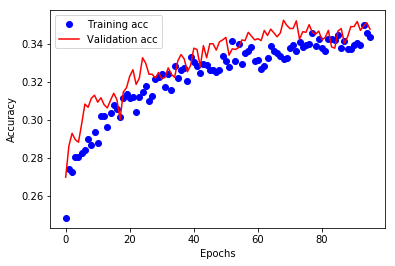

In [0]:
from matplotlib import pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
from sklearn.metrics import cohen_kappa_score

X_valid, Y_valid = attr_clf.test_data

Y_pred = attr_clf.predict(X_valid)

# Convert to numeric labels
Y_valid = np.argmax(Y_valid, -1)
Y_pred = np.argmax(Y_pred, -1)

print('Kappa:', cohen_kappa_score(Y_valid, Y_pred))


Kappa: 0.11352593396592947


#### Regression Attribute-only Model

We will try using regression techniques to better utilize the structure of the problem.

In [0]:
import numpy

# Attribute model data
X_attr, Y_attr = convert_for_single_axis(X, Y, ax=0)

# Shuffle the data
shuffle(X, Y)

# Validation split
(X_train, Y_train), (X_valid, Y_valid) = split(X_attr, Y_attr)

print('Training points:', len(Y_train))
print('Validation points:', len(Y_valid))
print('Total points:', len(Y))

attr_clf = RegModel((X_train, Y_train), (X_valid, Y_valid))

# Build the model
attr_clf.compile(optimizer=Adam(lr=2e-4))

import random
ivs = [0, 1, 7, 31, 90, 180]

def label(y):
    if y < 1:
        return 0
    elif y < 7:
        return 1
    elif y < 31:
        return 2
    elif y < 90:
        return 3
    else:
        return 4

def inv_label(x):
    return numpy.random.uniform(ivs[x], ivs[x+1])

epochs=96

history = attr_clf.train(epochs=epochs)
"""
# Fit to the data
for _ in range(epochs):
    #Ys = numpy.array([inv_label(y) for y in Y_train])
    history = attr_clf.model.fit(X_train, Y_train)
    
    Ys = attr_clf.model.predict(X_valid)
    Ys = [label(y) for y in Ys]
    acc = sum(Ys[i] == Y_valid[i] for i in range(len(Ys))) / len(Y_valid)
    print('val_acc:', acc)
"""

Training points: 11995
Validation points: 2998
Total points: 14993
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_free_encoder (Sequenti (None, 128)               21638     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_7 (Batch (None, 64)                256       
_________________________________________________________________
activation_4 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 30,215
Trainable params: 29,683
Non-trainable params: 532
___

"\n# Fit to the data\nfor _ in range(epochs):\n    #Ys = numpy.array([inv_label(y) for y in Y_train])\n    history = attr_clf.model.fit(X_train, Y_train)\n    \n    Ys = attr_clf.model.predict(X_valid)\n    Ys = [label(y) for y in Ys]\n    acc = sum(Ys[i] == Y_valid[i] for i in range(len(Ys))) / len(Y_valid)\n    print('val_acc:', acc)\n"

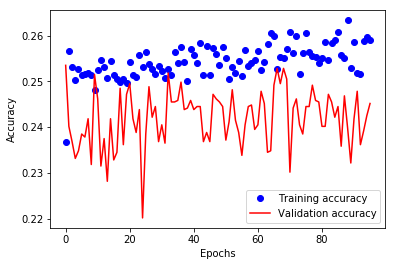

In [0]:
from matplotlib import pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
# Garbage collection prevents memory limit from being exceeded
del X_attr
del Y_attr
import gc
gc.collect()
attr_clf.val_acc

AttributeError: ignored

In [0]:
# Get the test data
X_test, ids = load_train_data(is_train=False)
X_test = X_test[0]

In [0]:
print(X_test.shape)
print(attr_clf.model.input_shape)

# Make predictions on the test data
Y_test = attr_clf.model.predict(X_test).flatten()

for i in range(len(Y_test)):
    x = Y_test[i]
    if x < 1:
        y = 0
    elif x < 7:
        y = 1
    elif x < 31:
        y = 2
    elif x < 90:
        y = 3
    else:
        y = 4
        
    Y_test[i] = y

Y_test.shape
print(Y_test[:100])

(3948, 23)
(None, 23)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


#### CNN Model

We will aim to learn from the images on their own.

In [0]:
from keras.preprocessing.image import ImageDataGenerator

# Create inputs for convolutional model
X_conv, Y_conv = convert_for_all(X, Y)
X_train = X_conv[1]

# Image generator for training
def make_generator(X):
    gen = ImageDataGenerator(
            rotation_range=40,
            zoom_range=0.2,
            shear_range=0.2,
            width_shift_range=0.2,
            height_shift_range=0.2,
            fill_mode='nearest',
            horizontal_flip=True,
    )
    gen.fit(X)
    return gen

Y_conv = to_categorical(Y_conv)

# Validation split
(X_train, Y_train), (X_valid, Y_valid) = split(X_train, Y_conv)
print('Training points:', len(Y_train))
print('Validation points:', len(Y_valid))
print('Total points:', len(Y))
print(X_train.shape, X_valid.shape)

train_gen = make_generator(X_train).flow(X_train, Y_train, batch_size=10)

Extracted 14993 datapoints
Training points: 46922
Validation points: 11730
Total points: 14993
(46922, 64, 64, 3) (11730, 64, 64, 3)


In [0]:
from keras.optimizers import *

# Build a model
conv_clf = SingleImageModel((X_train, Y_train), (X_valid, Y_valid))
#conv_clf = VggModel((X_train, Y_train), (X_valid, Y_valid))

# Train the model
conv_clf.compile(optimizer=Adam(lr=2e-4))
history = conv_clf.model.fit_generator(train_gen, steps_per_epoch = len(X_train) // 32, epochs=96, validation_data=(X_valid, Y_valid))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        9472      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
model_1 (Model)              (None, 64, 64, 64)        205440    
_________________________________________________________________
model_2 (Model)              (None, 64, 64, 64)        205440    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)    

In [0]:
conv_clf.val_acc = history.history['val_acc'][-1]
conv_clf.val_acc

0.28380222100913777

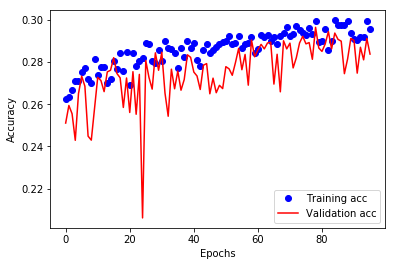

In [0]:
from matplotlib import pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
from sklearn.metrics import cohen_kappa_score, accuracy_score

X_valid, Y_valid = conv_clf.test_data

Y_pred = conv_clf.predict(X_valid)

# Convert to numeric labels
Y_valid = np.argmax(Y_valid, -1)
Y_pred = np.argmax(Y_pred, -1)

print('Accuracy:', accuracy_score(Y_valid, Y_pred))
print('Kappa:', cohen_kappa_score(Y_valid, Y_pred))

Accuracy: 0.28380221653878945
Kappa: 0.03451317223370476


In [0]:
del X_conv
del Y_conv
del X_train
del Y_train
del X_valid
del Y_valid
import gc
gc.collect()

0

#### Multi-Image Model

The motivation is to be able to use an arbitrary number of images to make a prediction.

In [0]:
# Attribute model data
X_poly, Y_poly = convert_for_poly(X, Y)
X_poly = X_poly[1]
print(X_poly.shape, Y_poly.shape)

# Image-free model
poly_clf = PolyImageModel

# Train the model
poly_clf = train_model(poly_clf, X_poly, Y_poly, epochs=32)

#### Union Model

A model using both attribute and image data.

In [0]:
# Create inputs for convolutional model
#X_conv, Y_conv = convert_for_all(X, Y)
#print('Built data')
#print([x.shape for x in X_conv])
#print(Y_conv.shape)

def make_union(tr, tst):
    attr = OheModel(tr, tst)
    conv = SingleImageModel(tr, tst)
    
    return UnionModel([attr, conv], tr, tst, freeze=False)

# Build a model
#union_clf = lambda tr, tst: UnionModel([attr_clf, conv_clf], tr, tst, freeze=True)
union_clf = make_union

# Train the model
union_clf = train_model(union_clf, X_conv, Y_conv)

#### Evaluation

In [0]:
# Get the test data
X, ids = load_train_data(is_train=False)
X = X[0]

In [0]:
# Make predictions on the test data
Y = attr_clf.model.predict(X)
Y = np.argmax(Y, -1)

In [0]:
# Save the results to a file
df = pd.DataFrame({
    'PetID': ids,
    'AdoptionSpeed':Y
})

print(df)

df.to_csv('results.csv', index=False)